In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('Housing_dataset_train.csv')
test = pd.read_csv('Housing_dataset_test.csv')
subm = pd.read_csv('Sample_submission.csv')

In [3]:
train.head()

,ID,loc,title,bedroom,bathroom,parking_space,price
0,3583,Katsina,Semi-detached duplex,2.0,2.0,1.0,1149999.565
1,2748,Ondo,Apartment,NaN,2.0,4.0,1672416.689
2,9261,Ekiti,NaN,7.0,5.0,NaN,3364799.814
3,2224,Anambra,Detached duplex,5.0,2.0,4.0,2410306.756
4,10300,Kogi,Terrace duplex,NaN,5.0,6.0,2600700.898


In [4]:
train.describe()

,ID,bedroom,bathroom,parking_space,price
count,14000.000000,12201.000000,12195.000000,12189.000000,1.400000e+04
mean,4862.700357,4.308171,3.134235,3.169825,2.138082e+06
std,3818.348214,2.441165,2.035950,1.599415,1.083057e+06
min,0.000000,1.000000,1.000000,1.000000,4.319673e+05
25%,1672.750000,2.000000,1.000000,2.000000,1.393990e+06
50%,3527.000000,4.000000,2.000000,3.000000,1.895223e+06
75%,8011.250000,6.000000,5.000000,4.000000,2.586699e+06
max,12999.000000,9.000000,7.000000,6.000000,1.656849e+07


In [5]:
train.isna().sum()

ID                  0
loc              1813
title            1722
bedroom          1799
bathroom         1805
parking_space    1811
price               0
dtype: int64

In [6]:
(train.isna().sum() / len(train)) * 100

ID                0.000000
loc              12.950000
title            12.300000
bedroom          12.850000
bathroom         12.892857
parking_space    12.935714
price             0.000000
dtype: float64

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             14000 non-null  int64  
 1   loc            12187 non-null  object 
 2   title          12278 non-null  object 
 3   bedroom        12201 non-null  float64
 4   bathroom       12195 non-null  float64
 5   parking_space  12189 non-null  float64
 6   price          14000 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 765.8+ KB


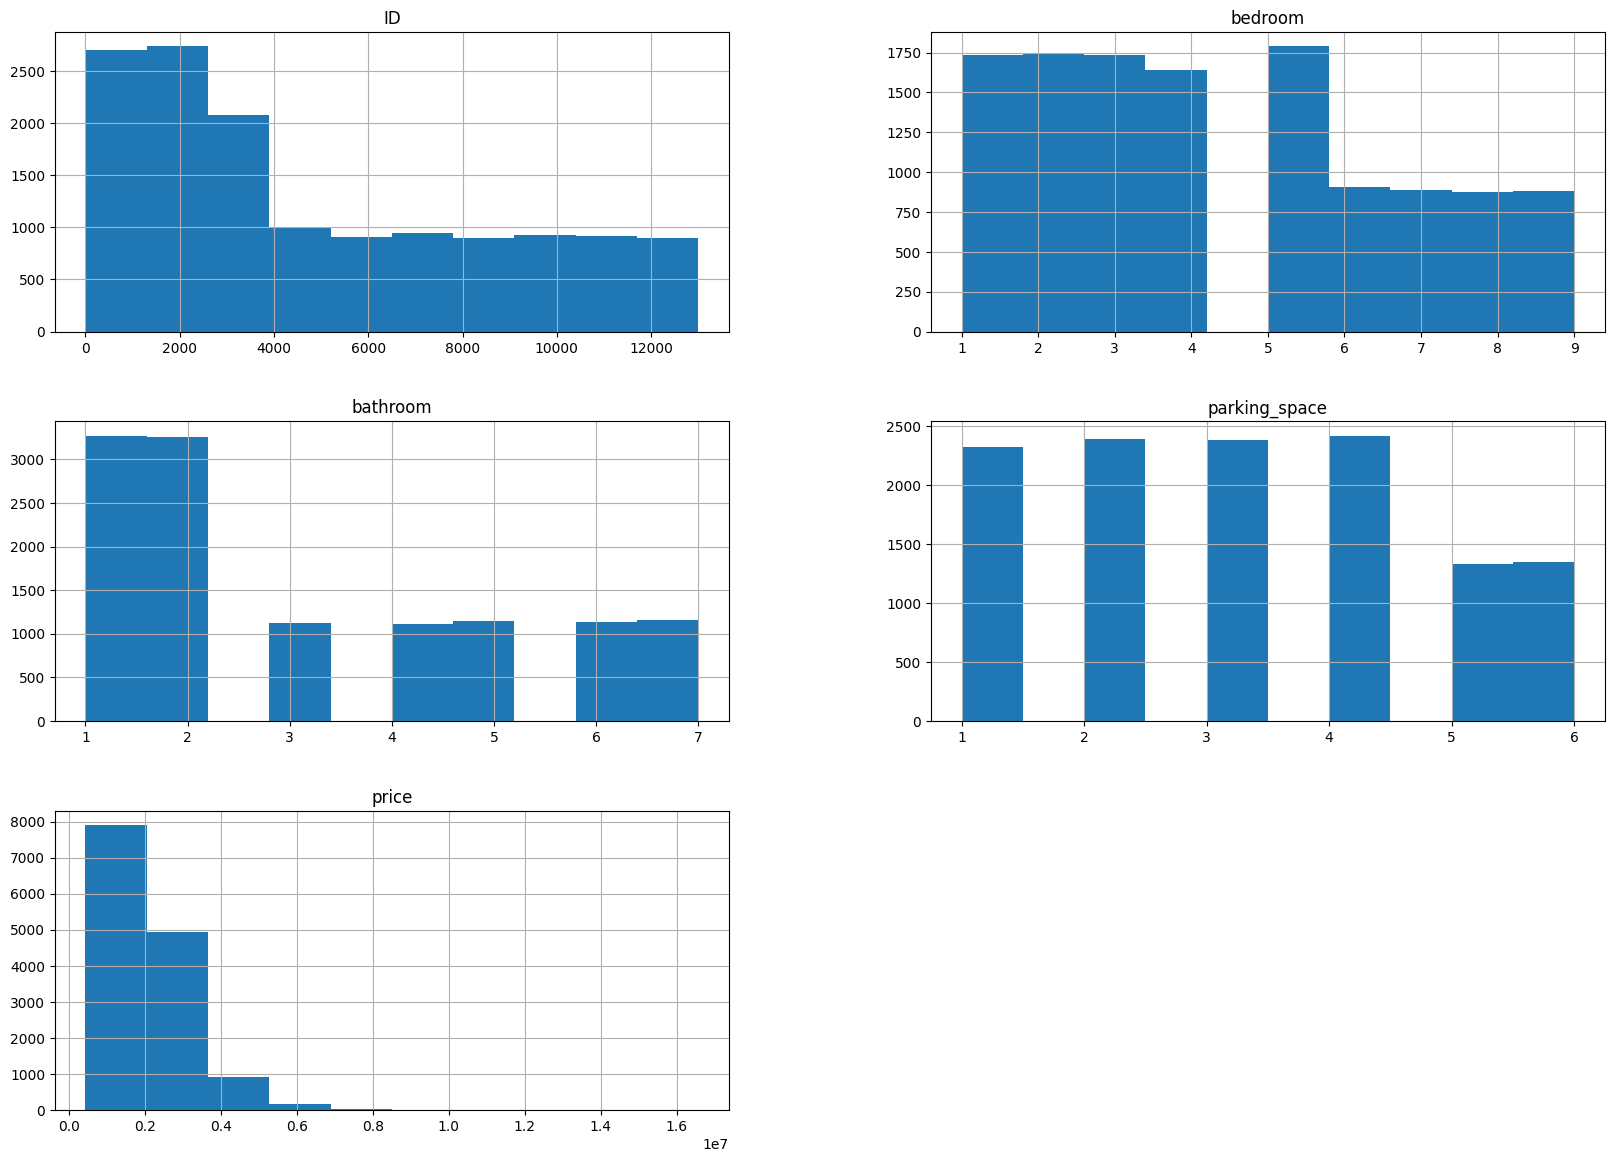

In [8]:
train.hist(figsize=(20, 14));

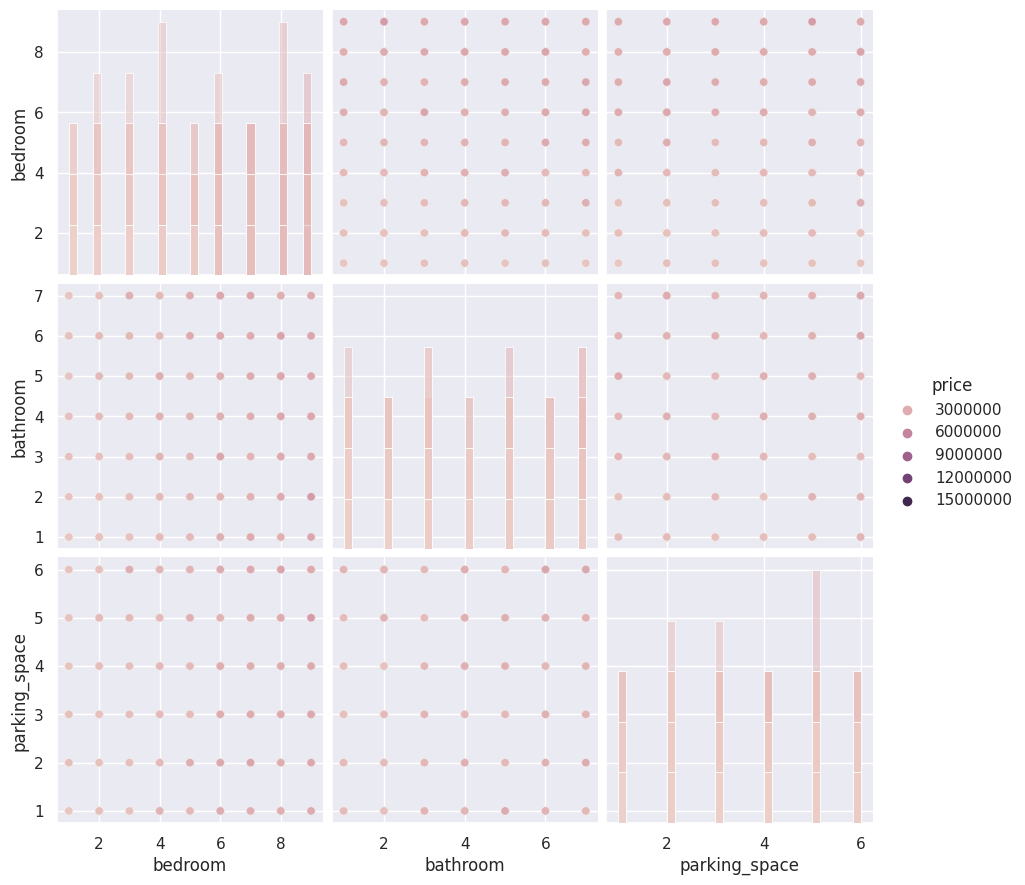

In [45]:
import seaborn as sns

target_column = 'price'
n_samples_to_plot = 5000
columns = ['bedroom','bathroom' ,'parking_space']
_ = sns.pairplot(
    data=train[:n_samples_to_plot],
    vars=columns,
    hue=target_column,
    plot_kws={"alpha": 0.2},
    height=3,
    diag_kind="hist",
    diag_kws={"bins": 30},
)

In [9]:
train['loc'].value_counts()

Kaduna         370
Anambra        363
Benue          355
Yobe           353
Borno          351
Kano           351
Nasarawa       349
Cross River    349
Zamfara        348
Imo            348
Ebonyi         346
Kebbi          346
Katsina        345
Ogun           345
Ondo           344
Gombe          343
Bauchi         342
Oyo            341
Adamawa        341
Bayelsa        340
Plateau        338
Osun           338
Jigawa         337
Ekiti          336
Kwara          333
Niger          330
Akwa Ibom      329
Lagos          328
Sokoto         326
Delta          325
Enugu          324
Rivers         323
Kogi           321
Taraba         315
Abia           312
Edo            302
Name: loc, dtype: int64

In [10]:
train['title'].value_counts()

Flat                    1372
Apartment               1331
Townhouse               1327
Mansion                 1322
Detached duplex         1312
Penthouse               1306
Semi-detached duplex    1299
Bungalow                1293
Terrace duplex          1266
Cottage                  450
Name: title, dtype: int64

In [12]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 6.4 MB/s eta 0:00:00


In [13]:
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')

In [14]:
train.describe()

,ID,bedroom,bathroom,parking_space,price
count,14000.000000,12201.000000,12195.000000,12189.000000,1.400000e+04
mean,4862.700357,4.308171,3.134235,3.169825,2.138082e+06
std,3818.348214,2.441165,2.035950,1.599415,1.083057e+06
min,0.000000,1.000000,1.000000,1.000000,4.319673e+05
25%,1672.750000,2.000000,1.000000,2.000000,1.393990e+06
50%,3527.000000,4.000000,2.000000,3.000000,1.895223e+06
75%,8011.250000,6.000000,5.000000,4.000000,2.586699e+06
max,12999.000000,9.000000,7.000000,6.000000,1.656849e+07


In [17]:
train.drop("price", axis=1).append(test).shape

(20000, 6)

In [18]:
data = train.drop("price", axis=1).append(test)

In [19]:
# Define the ranking based on size (arranged from smallest to biggest)
house_type_ranks = {
    'Cottage': 1,
    'Bungalow': 2,
    'Townhouse': 3,
    'Terrace duplex': 4,
    'Detached duplex': 5,
    'Semi-detached duplex': 6,
    'Flat': 7,
    'Penthouse': 8,
    'Apartment': 9,
    'Mansion': 10
}

# Map the house types to numerical values based on size ranking
data['title'] = data['title'].map(house_type_ranks)

# Print the updated dataframe
data.head()


,ID,loc,title,bedroom,bathroom,parking_space
0,3583,Katsina,6.0,2.0,2.0,1.0
1,2748,Ondo,9.0,NaN,2.0,4.0
2,9261,Ekiti,NaN,7.0,5.0,NaN
3,2224,Anambra,5.0,5.0,2.0,4.0
4,10300,Kogi,4.0,NaN,5.0,6.0


In [22]:
# Calculate the frequency of each category in the 'loc' column
category_frequencies = data['loc'].value_counts(normalize=True)

# Create a dictionary to map each category to its corresponding frequency
loc_frequency_mapping = category_frequencies.to_dict()

# Map the 'loc' column to its corresponding frequency values
data['loc'] = data['loc'].map(loc_frequency_mapping)

# Print the updated dataframe
data.head()

,ID,loc,title,bedroom,bathroom,parking_space
0,3583,0.028592,6.0,2.0,2.0,1.0
1,2748,0.028097,9.0,NaN,2.0,4.0
2,9261,0.027822,NaN,7.0,5.0,NaN
3,2224,0.029856,5.0,5.0,2.0,4.0
4,10300,0.027382,4.0,NaN,5.0,6.0


In [25]:
X = data[:train.shape[0]]
y = train.price
test_df = data[train.shape[0]:]

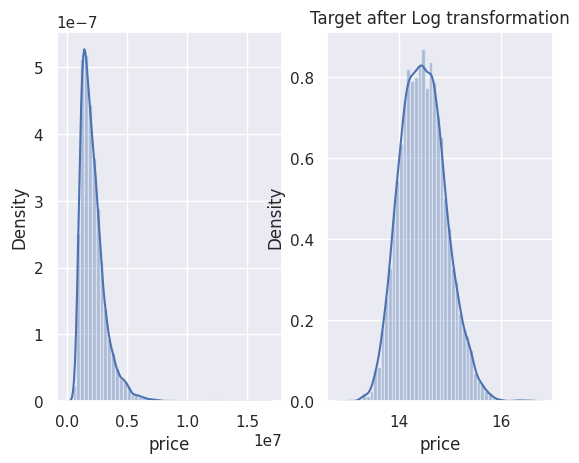

In [26]:
import seaborn as sns
sns.set()
y_transformed = pd.Series(np.log1p(y))

fig, ax = plt.subplots(1, 2)
sns.distplot(y, ax=ax[0])
plt.title("Target after Log transformation")
# ax[0].axvline(y_transformed)
sns.distplot(y_transformed, ax=ax[1])
plt.show()

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
lgb = LGBMRegressor()
lgb.fit(X_train, y_train)
lgb_preds = lgb.predict(X_test)

print(f'mse = {mean_squared_error(y_test, lgb_preds, squared=False)}')

mse = 592295.8375673272


In [29]:
predictions = lgb.predict(test_df)
predictions

array([2315313.77836646,  847985.77448807, 1116418.07946145, ...,
       2018114.35331414, 1420440.4714651 , 3168784.09197576])

In [31]:
subm['price'] = predictions
subm.head()

,ID,price
0,845,2.315314e+06
1,1924,8.479858e+05
2,10718,1.116418e+06
3,12076,7.349789e+06
4,12254,1.966154e+06


In [33]:
subm.to_csv('baseline model.csv', index=False)

In [34]:
!pwd

/content


In [35]:
fold_pred=[]
oof_pred = []

params = {
    'n_estimators': 500,
    'colsample_bytree': 0.86,
 'learning_rate': 0.032,
 'max_depth': 7,
 'subsample': 0.85}


fold = KFold(n_splits=7, shuffle=True)#15#5#10
i=1
for train_index, test_index in fold.split(X,y):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = np.log1p(y.iloc[train_index]), y.iloc[test_index]

    model = LGBMRegressor(**params, objective = "rmse")
    model.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)], early_stopping_rounds=100, verbose = False)#erly100

    preds= model.predict(X_test)
    print("err: ",(mean_squared_error(y_test,np.expm1(preds), squared=False)))  #Reverse transformation
    oof_pred.append(mean_squared_error(y_test,np.expm1(preds),squared=False))
    p2 = model.predict(test_df[X.columns])
    fold_pred.append(np.expm1(p2))


print(np.mean(oof_pred))

err:  602759.9937982694
err:  498809.4426016053
err:  537684.8076532966
err:  530257.0847101792
err:  547457.5802923499
err:  543716.1568789073
err:  588471.7342469774
549879.5428830836


Text(0.5, 1.0, 'CatboostClassifier features importance (top 50):')

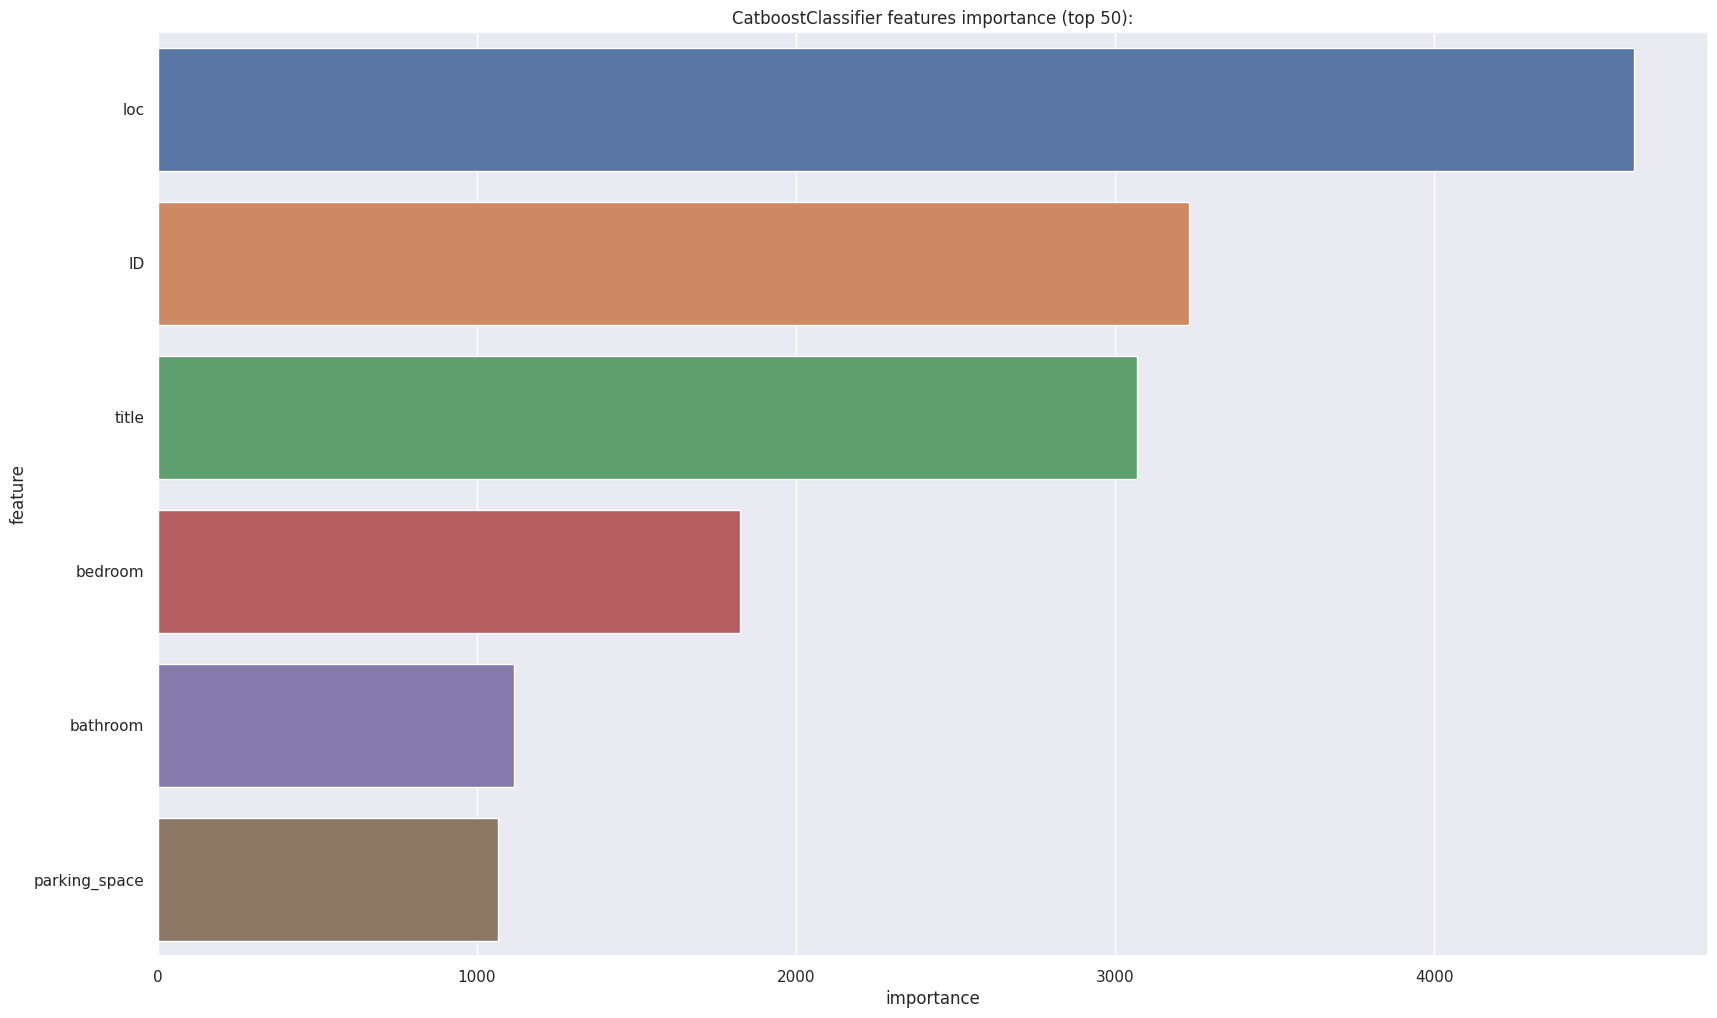

In [36]:
# # 0.7831404345536787
feature_importance_df = pd.DataFrame(model.feature_importances_, columns=['importance'])
feature_importance_df['feature'] = X.columns

plt.figure(figsize=(20, 12));
sns.barplot(x="importance", y="feature", data=feature_importance_df.sort_values(by = ['importance'], ascending = False).head(60))
plt.title('CatboostClassifier features importance (top 50):')

In [37]:
subm['price'] =  np.mean(fold_pred, axis = 0)

In [39]:
subm.to_csv('LGB kfold_7.csv', index=False)

In [40]:
train.head()

,ID,loc,title,bedroom,bathroom,parking_space,price
0,3583,Katsina,Semi-detached duplex,2.0,2.0,1.0,1149999.565
1,2748,Ondo,Apartment,NaN,2.0,4.0,1672416.689
2,9261,Ekiti,NaN,7.0,5.0,NaN,3364799.814
3,2224,Anambra,Detached duplex,5.0,2.0,4.0,2410306.756
4,10300,Kogi,Terrace duplex,NaN,5.0,6.0,2600700.898


<Axes: xlabel='bedroom'>

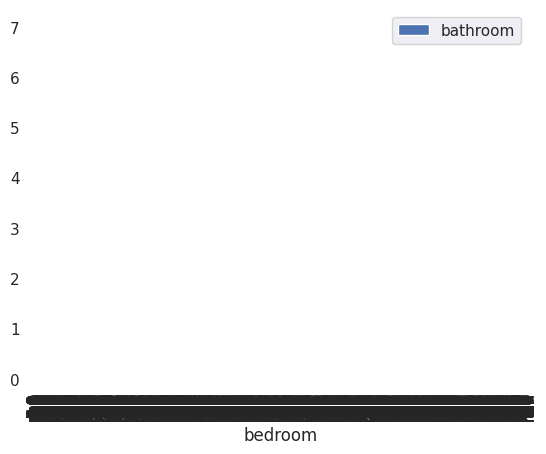

In [44]:
train.plot(x='bedroom', y='bathroom', kind='bar')

In [46]:
data.head()

,ID,loc,title,bedroom,bathroom,parking_space
0,3583,0.028592,6.0,2.0,2.0,1.0
1,2748,0.028097,9.0,NaN,2.0,4.0
2,9261,0.027822,NaN,7.0,5.0,NaN
3,2224,0.029856,5.0,5.0,2.0,4.0
4,10300,0.027382,4.0,NaN,5.0,6.0


In [47]:
data_new = data.copy()
data_new['bath_to_bed_ratio'] = data_new['bathroom'] / data_new['bedroom']
data_new.head()

,ID,loc,title,bedroom,bathroom,parking_space,bath_to_bed_ratio
0,3583,0.028592,6.0,2.0,2.0,1.0,1.000000
1,2748,0.028097,9.0,NaN,2.0,4.0,NaN
2,9261,0.027822,NaN,7.0,5.0,NaN,0.714286
3,2224,0.029856,5.0,5.0,2.0,4.0,0.400000
4,10300,0.027382,4.0,NaN,5.0,6.0,NaN


<Axes: ylabel='Frequency'>

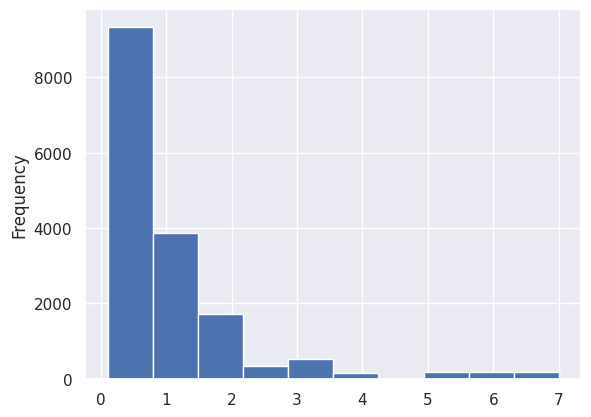

In [49]:
data_new['bath_to_bed_ratio'].plot(kind='hist')

In [50]:
X = data[:train.shape[0]]
y = train.price
test_df = data[train.shape[0]:]

In [51]:
fold_pred=[]
oof_pred = []

params = {
    'n_estimators': 500,
    'colsample_bytree': 0.86,
 'learning_rate': 0.032,
 'max_depth': 7,
 'subsample': 0.85}


fold = KFold(n_splits=7, shuffle=True)#15#5#10
i=1
for train_index, test_index in fold.split(X,y):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = np.log1p(y.iloc[train_index]), y.iloc[test_index]

    model = LGBMRegressor(**params, objective = "rmse")
    model.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)], early_stopping_rounds=100, verbose = False)#erly100

    preds= model.predict(X_test)
    print("err: ",(mean_squared_error(y_test,np.expm1(preds), squared=False)))  #Reverse transformation
    oof_pred.append(mean_squared_error(y_test,np.expm1(preds),squared=False))
    p2 = model.predict(test_df[X.columns])
    fold_pred.append(np.expm1(p2))


print(np.mean(oof_pred))

err:  586824.526276305
err:  516189.08708653995
err:  446760.21683163475
err:  514839.1884128653
err:  568904.4776935691
err:  707643.3069055199
err:  478956.1336450293
545730.9909787806


In [ ]:
# # 0.7831404345536787
feature_importance_df = pd.DataFrame(model.feature_importances_, columns=['importance'])
feature_importance_df['feature'] = X.columns

plt.figure(figsize=(20, 12));
sns.barplot(x="importance", y="feature", data=feature_importance_df.sort_values(by = ['importance'], ascending = False).head(60))
plt.title('CatboostClassifier features importance (top 50):')

In [52]:
subm['price'] =  np.mean(fold_pred, axis = 0)

subm.to_csv('LGB_test_ratio.csv', index=False)

In [53]:
from catboost import CatBoostRegressor

In [ ]:
fold_pred=[]
oof_pred = []

params = {
    'n_estimators': 1000,
    # 'colsample_bytree': 0.86,
 'learning_rate': 0.001,
 'max_depth': 6,
 'subsample': 0.85}


fold = KFold(n_splits=10, shuffle=True)#15#5#10
i=1
print('CatBoostRegressor  with SQRT Transformation')
for train_index, test_index in fold.split(X,y):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = np.sqrt(y.iloc[train_index]), y.iloc[test_index]

    model = CatBoostRegressor(**params, loss_function = "RMSE")
    model.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)], early_stopping_rounds=100, verbose = False)#erly100

    preds= model.predict(X_test)
    print("err: ",(mean_squared_error(y_test,np.square(preds), squared=False)))  #Reverse transformation
    oof_pred.append(mean_squared_error(y_test,np.sqaure(preds),squared=False))
    p2 = model.predict(test_df[X.columns])
    fold_pred.append(np.sqaure(p2))


print(np.mean(oof_pred))

CatBoostRegressor  with SQRT Transformation
err:  731372.1272643467


AttributeError: ignored